![img](https://www.kdnuggets.com/wp-content/uploads/text-preprocessing-framework-2.png)

In [1]:
#! pip install contractions

In [2]:
#! pip install inflect

In [3]:
#! pip install wget

In [44]:
import pandas as pd
import numpy as np
import nltk.data
from nltk import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from gensim.models import FastText
import contractions
import inflect
import re, unicodedata
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import SnowballStemmer

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, \
                          UpSampling1D, LSTM, RepeatVector, TimeDistributed
from keras.utils import plot_model
from sklearn.neighbors import NearestNeighbors
from keras.utils.vis_utils import plot_model
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#import my_functions

pd.set_option('max_colwidth', 250)

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Enric\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Enric\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
STOPWORDS_ESP = list(set(stopwords.words('spanish')))
STOPWORDS_CAT = open('stopwords_catalan.txt', 'r', encoding= 'UTF-8').read().split()
STOPWORDS_ENG = list(set(stopwords.words('english')))
CUSTOM  = ['uf', '100st', '100t', '100u', 'pal', 'zzb21601xu', 'x2']

STOPWORDS_ALL = STOPWORDS_ESP + STOPWORDS_CAT + STOPWORDS_ENG + CUSTOM

In [7]:
import wget

print('Beginning file download with wget module')

url = 'https://raw.githubusercontent.com/michmech/lemmatization-lists/master/lemmatization-es.txt'  
#wget.download(url) 

Beginning file download with wget module


In [4]:
lemmatizer = {}
with open("lemmatization-es.txt", encoding= 'UTF-8') as f:
    for line in f:
        try:
            (key, val) = line.split()
        except:
            pass
        lemmatizer[str(key)] = val

In [5]:
lemmatizer_inv = {v: k for k, v in lemmatizer.items()}

In [6]:
#lemmatizer_inv

In [7]:
data = pd.read_csv('../02_Comprension de Datos/Descripciones204k_20190315.csv', sep = ';')

In [8]:
data.head()

,id,brand,text
0,1060651400131,Woman_Limited_El_Corte_Inglés,Moda Mujer Abrigos Abrigo masculino con textura de mujer
1,1060651400180,Woman_Limited_El_Corte_Inglés,Moda Mujer Abrigos Abrigo doble faz de mujer con cinturón a tono
2,1051056400107,Woman_El_Corte_Inglés,Moda Mujer Abrigos Abrigo largo de antelina de mujer Woman El Corte Inglés
3,1019350401147,Lloyd's,Moda Mujer Abrigos Chaqueta térmica de mujer Lloyds con efecto cortavientos
4,1019353400229,Lloyd's,Moda Mujer Abrigos Parka 100% algodón de mujer Lloyds con capucha


Creamos una lista de marcas para poder quitarlas del texto en caso de que aparezcan, eliminamos las marcas duplicadas para comprimir el tamaño de la lista y optimizar el proceso de bsuqueda

In [9]:
data.loc[199000]

id                                        1025942232486
brand                                          Fox_Home
text     Cine Series de Tv Futurama. 7ª Temporada (DVD)
Name: 199000, dtype: object

In [10]:
copia = data.copy()

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def normalize_brands(words):
    words = str(words)
    words  = words.strip().split()
    words = to_lowercase(words)
    words = remove_punctuation(words)    
    words = list(dict.fromkeys(words)) #Remove duplicates
    words = " ".join(words)
    return words
    
copia['brand'] = copia['brand'].apply(normalize_brands)
brands = list(dict.fromkeys(copia['brand'].values))
brands.remove('marvel')
more_brands = ['tarocco', 'tucci', 'fjord', 'tommy', 'hilfiger', 'easy', 'wear', 'josma', 'jaipur', 'ralph', 'nemeziz']
for brand in more_brands:
    brands.append(brand)

In [11]:
len(brands)

5091

## Normalizacion

Con la normalización vamos a realizar una serie de tareas destinadas a poner todo el texto en un campo de juego nivelado: convertir todo el texto a la misma mayúscula o minúscula, eliminar la puntuación, convertir las cifras a sus equivalentes en palabras, etc. La normalización pone todas las palabras en pie de igualdad y permite que el procesamiento se realice de manera uniforme. Algunas de las técnicas que vamos a aplicar son:

- Borrar caracteres extraños
- Pasar todo el texto a minusculas
- Quitar simbolos de puntuacion ( . , &, !, ?, ¿, /, etc)
- Pasar numeros en digito a texto
- Quitar stopwords
- Stemming
- Lexematizar

**Importante:** Despues de la Nomralizacion trabajaremos a nivel de palabra o token en vez de a nivel de texto

In [12]:
ngrams = ['corte ingles', 'bob esponja', 'color azul', 'cristiano ronaldo', 'fc barcelona', 'lionel messi', 'real madrid',
         'azul oscuro', '1a temporada', '2a temporada', '3a temporada', '4a temporada', '5a temporada', '6a temporada',
         '7a temporada', '8a temporada', 'mrs increible', 'mr increible', 'fc barcelona']

In [13]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        #new_word = unicodedata.normalize('NFD', word).encode('ascii', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Remove all interger occurrences in list"""
    new_words = []
    for word in words:
        if not word.isdigit():
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in STOPWORDS_ALL and len(word) > 1:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def remove_brands(words):
    """Remove brands from the text"""
    clean_words = []
    for word in words:
        if word not in brands:
            clean_words.append(word)
    return clean_words

def lemmatize(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmas = []
    for word in words:
        if word in lemmatizer_inv:
            lemmas.append(lemmatizer_inv[word])
        else: lemmas.append(word)
    return lemmas

def replace_ngrams(words):
    for gram in ngrams:
        if (gram in words):
            g = "_".join(gram.split())
            words = words.replace(gram, g)
    return words

def normalize(words):
    #if pandas == True:
    words  = words.strip().split()
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_brands(words)
    words = remove_stopwords(words)
    words = lemmatize(words)
    words = replace_numbers(words)
    words = remove_non_ascii(words)
    words = list(dict.fromkeys(words)) #Remove duplicates
    words = " ".join(words)
    words = replace_ngrams(words)
    return words


In [34]:
data_copy = data.copy()

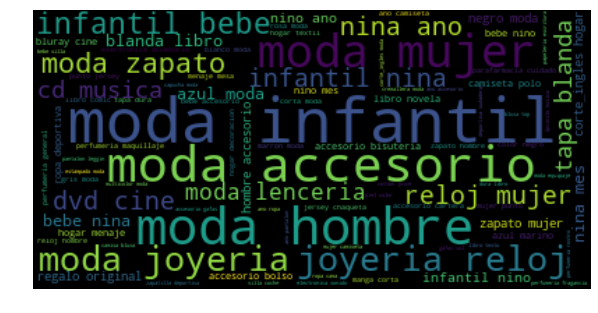

In [50]:
text =  WordCloud().generate(data_copy['text'].to_string())
plt.figure(figsize=(10,10))
plt.imshow(text, interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
%%time
#4min 4sec
data_copy['text'] = data_copy['text'].apply(normalize)

Wall time: 9min 5s


In [20]:
data_copy.head(5)

,id,brand,text
0,1060651400131,Woman_Limited_El_Corte_Inglés,moda mujer abrigo masculino textura
1,1060651400180,Woman_Limited_El_Corte_Inglés,moda mujer abrigo doble faz cinturon tono
2,1051056400107,Woman_El_Corte_Inglés,moda mujer abrigo largo antelina woman corte_ingles
3,1019350401147,Lloyd's,moda mujer abrigo chaqueta termica efecto cortavientos
4,1019353400229,Lloyd's,moda mujer abrigo parka algodon capucha


In [21]:
data.head(5)

,id,brand,text
0,1060651400131,Woman_Limited_El_Corte_Inglés,Moda Mujer Abrigos Abrigo masculino con textura de mujer
1,1060651400180,Woman_Limited_El_Corte_Inglés,Moda Mujer Abrigos Abrigo doble faz de mujer con cinturón a tono
2,1051056400107,Woman_El_Corte_Inglés,Moda Mujer Abrigos Abrigo largo de antelina de mujer Woman El Corte Inglés
3,1019350401147,Lloyd's,Moda Mujer Abrigos Chaqueta térmica de mujer Lloyds con efecto cortavientos
4,1019353400229,Lloyd's,Moda Mujer Abrigos Parka 100% algodón de mujer Lloyds con capucha


In [22]:
#7000
print(data.loc[199000])
print(data_copy.loc[89000])

id                                        1025942232486
brand                                          Fox_Home
text     Cine Series de Tv Futurama. 7ª Temporada (DVD)
Name: 199000, dtype: object
id                                       1014970203072
brand                                Polo_Ralph_Lauren
text     moda mujer punto jersey lana polo cuello caja
Name: 89000, dtype: object


In [23]:
data_copy['text'].shape

(204812,)

In [24]:
maxw = 0
mean = 0
max_s = 0
for i, sentence in enumerate(data_copy['text']):
    mean += len(sentence.split())
    if maxw < len(sentence.split()):
        maxw = len(sentence.split())
        max_s = i
print('Max words in a sentence:' + ' '*10 + 'Mean words in a sentence:')
print("-" * 60)
print (f"{maxw} {' '*30} {mean/len(data_copy['text'])}")
print("-" * 60)
print (data_copy['text'][max_s])

Max words in a sentence:          Mean words in a sentence:
------------------------------------------------------------
23                                8.059176220143351
------------------------------------------------------------
libro salud bienestar dieta nutricion general detox sen sano dentro bello clave nutricional rutina diarias eliminar toxina forma saludable energetica nutritiva tapa blanda


In [25]:
data_copy.to_csv('Texto_PreProcesado.csv', sep = ';', index = False)

### N-gramas (CountVectorizer)

In [26]:
bag_of_words = nltk.word_tokenize(data_copy['text'].to_string())
bag_of_words = list(dict.fromkeys(bag_of_words))
print(bag_of_words[:10])
print(len(bag_of_words)) 
#126k productos = 2_063_845 palabras
#175k productos = 2_838_097 palabras
#204k productos = 3_070_773 palabras -> 1_878_308 20/03/2019 -> no dups = 257042, ngrams =257063 

['0', 'moda', 'mujer', 'abrigo', 'masculino', 'textura', '1', 'doble', 'faz', 'cinturon']
257064


In [27]:
corpus = [sent for sent in data_copy['text']]
corpus[0:5]

['moda mujer abrigo masculino textura',
 'moda mujer abrigo doble faz cinturon tono',
 'moda mujer abrigo largo antelina woman corte_ingles',
 'moda mujer abrigo chaqueta termica efecto cortavientos',
 'moda mujer abrigo parka algodon capucha']

In [28]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)

In [29]:
list(vectorizer.vocabulary_.keys())[0:10]

['moda',
 'mujer',
 'abrigo',
 'masculino',
 'textura',
 'moda mujer',
 'mujer abrigo',
 'abrigo masculino',
 'masculino textura',
 'doble']

---

## Word2Vec


In [30]:
EMBEDDING_DIM = 200

In [31]:
sentences = [word.split() for word in data_copy['text'].values]
sentences[:3]

[['moda', 'mujer', 'abrigo', 'masculino', 'textura'],
 ['moda', 'mujer', 'abrigo', 'doble', 'faz', 'cinturon', 'tono'],
 ['moda', 'mujer', 'abrigo', 'largo', 'antelina', 'woman', 'corte_ingles']]

In [32]:
len(sentences)

204812

In [33]:
%%time
modelWV = Word2Vec(sentences, workers = 3, min_count=5, window = 10, size = EMBEDDING_DIM)
modelWV.train(sentences, total_examples=len(sentences), epochs=50)

Wall time: 2min 39s


In [34]:
modelWV.save("word2vec_model_v2")

In [35]:
#model = Word2Vec.load("word2vec_model_v1")
wl = 'sandalia'
modelWV.wv.most_similar (positive = wl)
#model.wv.most_similar_cosmul(positive = ['disfraz', 'abrigo'])

[('alpargata', 0.6290709972381592),
 ('botin', 0.6135832667350769),
 ('salon', 0.5850276947021484),
 ('mocasin', 0.5569319725036621),
 ('chancla', 0.5555477142333984),
 ('bota', 0.5497039556503296),
 ('mercedita', 0.5435197353363037),
 ('nautico', 0.5411031246185303),
 ('pepito', 0.5364699363708496),
 ('deportivas', 0.5191572308540344)]

In [36]:
def similar_products(text):
    text = normalize(text)
    list_text = text.split()
    most_similar = modelWV.wv.most_similar_cosmul(positive = list_text)
    
    return most_similar
    
similar_products('Silla de paseo')

[('maternal', 0.47183555364608765),
 ('carrycot', 0.4686814248561859),
 ('cambiador', 0.4548194706439972),
 ('born', 0.45320045948028564),
 ('portabebes', 0.44677817821502686),
 ('isofix', 0.4405463933944702),
 ('trona', 0.4361507296562195),
 ('seat', 0.4346296489238739),
 ('gemelar', 0.4344612658023834),
 ('capazo', 0.4313882887363434)]

---

## Vectorize Sentences

- Initialize tokenizer with num_words = MAX_NB_WORDS (200K). i.e. The tokenizer will perform a word count, sorted by number of occurences in descending order and pick top N words, 200K in this case 
- Use tokenizer's texts_to_sequences method to convert text to array of integers.
- The arrays obtained from previous step might not be of uniform length, use pad_sequences method to obtain arrays with length equal to MAX_SEQUENCE_LENGTH (30)

In [37]:
MAX_NB_WORDS = len(bag_of_words) #257_064k
MAX_SEQUENCE_LENGTH = 24                                

In [38]:
all_text = data_copy['text']
all_text = all_text.drop_duplicates (keep = False)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, )
tokenizer.fit_on_texts(all_text)

data_sequences = tokenizer.texts_to_sequences(data_copy['text'])
data_vec = pad_sequences(data_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [39]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
#49421

Found 49418 unique tokens.


In [80]:
word_index

{'moda': 1,
 'accesorio': 2,
 'mujer': 3,
 'bebe': 4,
 'infantil': 5,
 'hombre': 6,
 'cine': 7,
 'hogar': 8,
 'azul': 9,
 'libro': 10,
 'electronica': 11,
 'deporte': 12,
 'musica': 13,
 'nina': 14,
 'tapa': 15,
 'dvd': 16,
 'negro': 17,
 'corte': 18,
 'juguete': 19,
 'nino': 20,
 'ingles': 21,
 'perfumeria': 22,
 'mes': 23,
 'color': 24,
 'regalo': 25,
 'ano': 26,
 'cd': 27,
 'zapato': 28,
 'original': 29,
 'blanda': 30,
 'piel': 31,
 'juego': 32,
 'gris': 33,
 'ropa': 34,
 'papeleria': 35,
 'rosa': 36,
 'menaje': 37,
 'electrodomestico': 38,
 'blanco': 39,
 'bolso': 40,
 'cocina': 41,
 'estampado': 42,
 'mesa': 43,
 'camiseta': 44,
 'silla': 45,
 'novela': 46,
 'zapatilla': 47,
 'bluray': 48,
 'pantalon': 49,
 'paseo': 50,
 'bano': 51,
 'pack': 52,
 'rostro': 53,
 'coche': 54,
 'bisuteria': 55,
 'decoracion': 56,
 'reloj': 57,
 'jersey': 58,
 'chaqueta': 59,
 'punto': 60,
 'rojo': 61,
 'camisa': 62,
 'manga': 63,
 'marino': 64,
 'marron': 65,
 'cuidado': 66,
 'general': 67,
 'funda':

In [41]:
data_vec[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    3,   94,
       2461, 1432])

A word_index has a unique ID assigned to each word in the data. Example:

In [42]:
word_index = tokenizer.word_index
test_string = "ropa deporte abrigo raqueta bebe"
print("word\t\tid")
print("-" * 20)
for word in test_string.split():
    print("%s\t\t%s" % (word, word_index[word]))

word		id
--------------------
ropa		34
deporte		12
abrigo		94
raqueta		1645
bebe		4


In [43]:
EMBEDDING_DIM=200

In [44]:
word_vectors = modelWV.wv
vocabulary_size = len(word_index) + 1
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in modelWV:
        embedding_matrix[i] = modelWV[word]
    else:
        embedding_matrix[i] = np.random.rand(1, EMBEDDING_DIM)[0]
            

del(word_vectors)

embedding_layer = Embedding(input_dim = vocabulary_size,
                            output_dim = EMBEDDING_DIM,
                            input_length = MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            name='w2v_embedding',
                            trainable=False)

C:\Users\Enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
C:\Users\Enric\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


In [45]:
modelWV.save("w2v_embedding_v1_1.h5")

In [46]:
embedding_layer_2 = modelWV.wv.get_keras_embedding()

In [47]:
VOCAB_SIZE = word_index
#timesteps = X_train.shape[0]

In [48]:
#! conda install python-pydot

In [49]:
#! conda install python-graphviz

### Densas

In [50]:
X_train = np.vstack(data_vec)
X_train.shape

(204812, 24)

In [51]:
model = Sequential()
model.add(embedding_layer)
model.compile('rmsprop', 'mse')

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
w2v_embedding (Embedding)    (None, 24, 200)           9883800   
Total params: 9,883,800
Trainable params: 0
Non-trainable params: 9,883,800
_________________________________________________________________


In [53]:
input_i = Input(shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM))
encoded_h1 = Dense(128, activation='relu')(input_i)
encoded_h2 = Dense(64, activation='relu')(encoded_h1)
encoded_h3 = Dense(32, activation='relu')(encoded_h2)
encoded_h4 = Dense(16, activation='relu')(encoded_h3)
#encoded_h5 = Dense(8, activation='relu')(encoded_h4)

latent = Dense(8, activation='relu', name = 'ENCODER')(encoded_h4)

#decoder_h1 = Dense(8, activation='relu')(latent)
decoder_h2 = Dense(16, activation='relu')(latent)
decoder_h3 = Dense(32, activation='relu')(decoder_h2)
decoder_h4 = Dense(64, activation='relu')(decoder_h3)
decoder_h5 = Dense(128, activation='relu')(decoder_h4)

output = Dense(EMBEDDING_DIM, activation='relu')(decoder_h5)

autoencoder = Model(input_i,output)

autoencoder.compile('rmsprop','mse')

In [54]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 200)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 24, 128)           25728     
_________________________________________________________________
dense_2 (Dense)              (None, 24, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 24, 32)            2080      
_________________________________________________________________
dense_4 (Dense)              (None, 24, 16)            528       
_________________________________________________________________
ENCODER (Dense)              (None, 24, 8)             136       
_________________________________________________________________
dense_5 (Dense)              (None, 24, 16)            144       
__________

In [55]:
X_embedded = model.predict(X_train, verbose = 1)

204812/204812 [==============================] - 12s 60us/step


In [56]:
%%time
autoencoder.fit(X_embedded,X_embedded,epochs=3,
            batch_size=32, verbose = 1)

Epoch 1/3
204812/204812 [==============================] - 188s 919us/step - loss: 0.6560
Epoch 2/3
204812/204812 [==============================] - 177s 864us/step - loss: 0.6103
Epoch 3/3
204812/204812 [==============================] - 184s 900us/step - loss: 0.5960
Wall time: 9min 10s


In [59]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('ENCODER').output)

In [60]:
#encoder.save('encoder_text_V1.h5')
#autoencoder = load_model('autoencoder_v2.h5')

In [63]:
#plot_model(model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

### Most similar Products

In [64]:
X_train[20000].shape

(24,)

In [69]:
data.loc[160700]

id                                         001097632608283
brand                                               Ludilo
text     Juguetes Juegos de mesa Habilidad Caperucita Roja
Name: 160700, dtype: object

In [70]:
query = X_embedded[160700]

In [71]:
X_test = X_embedded.copy()
X_test.shape

(204812, 24, 200)

In [72]:
%%time
codes = encoder.predict(X_test)
codes.shape

Wall time: 46.9 s


In [73]:
query_code = encoder.predict(query.reshape(1,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM))
query_code.shape

(1, 24, 8)

In [74]:
codes = codes.reshape(-1, 24*8)
print(codes.shape)
query_code = query_code.reshape(1, 24*8)
print(query_code.shape)

(204812, 192)
(1, 192)


### Fit the KNN to the test set

In [75]:
%%time
n_neigh = 10
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)

Wall time: 8min 16s


In [76]:
distances, indices = nbrs.kneighbors(np.array(query_code))

In [77]:
closest_sent = X_test[indices]
closest_sent = closest_sent.reshape(-1,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM); 
print(closest_sent.shape)

(10, 24, 200)


## Get the closest text

In [78]:
data.loc[160700]

id                                         001097632608283
brand                                               Ludilo
text     Juguetes Juegos de mesa Habilidad Caperucita Roja
Name: 160700, dtype: object

In [79]:
mis_indices = indices.tolist()[0]
for i in range(n_neigh):
    print (data.loc[mis_indices[i]])
    print('-'*50)

id                                         001097632608283
brand                                               Ludilo
text     Juguetes Juegos de mesa Habilidad Caperucita Roja
Name: 160700, dtype: object
--------------------------------------------------
id                                                 001097631222540
brand                                                     Fournier
text     Juguetes Juegos de mesa Habilidad Baraja infantil Grojuss
Name: 160683, dtype: object
--------------------------------------------------
id                                                 001003916512670
brand                                                     Fournier
text     Juguetes Juegos de mesa Habilidad Baraja infantil Grojuss
Name: 160685, dtype: object
--------------------------------------------------
id                                          001097631508690
brand                                              IMC_Toys
text     Juguetes Juegos de mesa Habilidad Atrapa Estrellas
Name